### Jaeger vs Kaiju Spans Timing ###

##### Gaussian distribution with 2 hotrod#####
*  5000 _requests_
* _seed_ = "EXP"
* _m_=2 _var_=2
* _Time Interval_ = 2000

In [1]:
import matplotlib.pyplot as pyplot
import numpy as np

In [16]:
timings = [np.genfromtxt('api_csv/bigLoad_u_5000_jaegerLookBack120/1sec/kaijuTiming_1.csv', delimiter=', ', dtype='str'),
         np.genfromtxt('api_csv/bigLoad_u_5000_jaegerLookBack120/1sec/kaijuTiming_2.csv', delimiter=', ', dtype='str'),
         np.genfromtxt('api_csv/bigLoad_u_5000_jaegerLookBack120/1sec/kaijuTiming_3.csv', delimiter=', ', dtype='str')]
traceId = []
spanId = []
startTime = []
duration = []
eventTime = []
t_end_span =[]
t_diff = []

for timing in timings:
    traceId.append(np.array(timing[0:,0]))
    spanId.append(np.array(timing[0:,1]))
    startTime.append(np.array(timing[0:,2]).astype(np.int64))
    duration.append(np.array(timing[0:,3]).astype(np.int64))
    eventTime.append(np.array(timing[0:,4]).astype(np.int64))
    t_end_span.append(np.add(startTime[-1], duration[-1]))
    t_diff.append(np.subtract(eventTime[-1], t_end_span[-1]))

j_timings  = [np.genfromtxt('api_csv/bigLoad_u_5000_jaegerLookBack120/1sec/jaegerTiming_1.csv', delimiter=', ', dtype='str'),
              np.genfromtxt('api_csv/bigLoad_u_5000_jaegerLookBack120/1sec/jaegerTiming_2.csv', delimiter=', ', dtype='str'),
              np.genfromtxt('api_csv/bigLoad_u_5000_jaegerLookBack120/1sec/jaegerTiming_3.csv', delimiter=', ', dtype='str')]
j_traceId = []
j_spanId = []
j_startTime = []
j_duration = []
j_eventTime = []
j_t_end_span =[]
j_t_diff = []

for j_timing in j_timings:
    j_traceId.append(np.array(j_timing[0:,0]))
    j_spanId.append(np.array(j_timing[0:,1]))
    j_startTime.append(np.array(j_timing[0:,2]).astype(np.int64))
    j_duration.append(np.array(j_timing[0:,3]).astype(np.int64))
    j_eventTime.append(np.array(j_timing[0:,4]).astype(np.int64))
    j_t_end_span.append(np.add(j_startTime[-1], j_duration[-1]))
    j_t_diff.append(np.subtract(j_eventTime[-1], j_t_end_span[-1]))

In [17]:
for i in range(3):
    print("TEST NUMBER " + str(i + 1))
    print("Kaiju Traces: " + str(np.unique(traceId[i]).shape[0]))
    print("Jaeger Traces: " + str(np.unique(j_traceId[i]).shape[0]))
    # print("Traces in Kaiju and not in Jaeger " + str((np.setdiff1d(traceId[i], j_traceId[i]).tolist())))
    # print("Traces in Jaeger and not in Kaiju " + str((np.setdiff1d(j_traceId[i], traceId[i]).tolist())))
    print("")
    concat_traces_span = np.core.defchararray.add(np.core.defchararray.add(traceId[i], " "), spanId[i])
    j_concat_traces_span = np.core.defchararray.add(np.core.defchararray.add(j_traceId[i], " "), j_spanId[i])
    print("Kaiju Spans: " + str(np.unique(concat_traces_span).shape[0]))
    print("Jaeger Spans: " + str(np.unique(j_concat_traces_span).shape[0]))
    # print("Spans (traceId spanId) in Kaiju and not in Jaeger " + str(len(np.setdiff1d(concat_traces_span, j_concat_traces_span).tolist())))
    # print("Spans (traceId spanId) in Jaeger and not in Kaiju " + str(len(np.setdiff1d(j_concat_traces_span, concat_traces_span).tolist())))
    print("*******************************************************************\n")

TEST NUMBER 1
Kaiju Traces: 4730
Jaeger Traces: 4136

Kaiju Spans: 181626
Jaeger Spans: 175254
*******************************************************************

TEST NUMBER 2
Kaiju Traces: 4768
Jaeger Traces: 4266

Kaiju Spans: 192449
Jaeger Spans: 185097
*******************************************************************

TEST NUMBER 3
Kaiju Traces: 4777
Jaeger Traces: 4258

Kaiju Spans: 189596
Jaeger Spans: 184450
*******************************************************************



#### Queries to InfluxDB

```SELECT max(counter) FROM "kaiju"."autogen"."hotrod_jaeger_agent:tc_reporter:jaeger:spans_submitted" GROUP BY "instance" ```

```SELECT max("counter") FROM "kaiju"."autogen"."jaeger_collector_spans_received"```

```SELECT max("counter") FROM "kaiju"."autogen"."jaeger_collector_traces_received"```


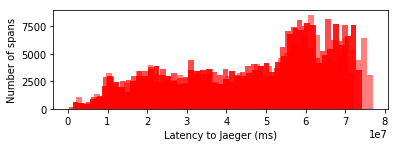

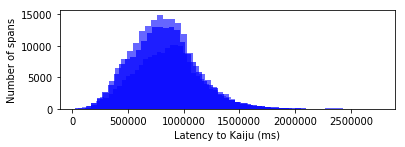

In [18]:
pyplot.subplot(2, 1, 1)
for i in range(3):
    a = 0.5 + float("0." + str(i))*2
    l = "Jaeger " + str(i)
    pyplot.hist(j_t_diff[i], 50, alpha=a, color='r', label=l)
pyplot.xlabel('Latency to Jaeger (ms)')
pyplot.ylabel('Number of spans')
pyplot.show()

pyplot.subplot(2, 1, 2)
for i in range(3):
    a = 0.5 + float("0." + str(i))
    l = "Kaiju " + str(i)
    pyplot.hist(t_diff[i], 50, alpha=a, color='b', label = l)
pyplot.xlabel('Latency to Kaiju (ms)')
pyplot.ylabel('Number of spans')
pyplot.show()

TEST NUMBER 1
Min latency: Kaiju 2127160ms Jaeger 53938ms
Max latency: Kaiju 77051752ms Jaeger 2007662ms
*******************************************************************

TEST NUMBER 2
Min latency: Kaiju 186709ms Jaeger 60817ms
Max latency: Kaiju 72185384ms Jaeger 2755224ms
*******************************************************************

TEST NUMBER 3
Min latency: Kaiju 1174331ms Jaeger 25261ms
Max latency: Kaiju 74302613ms Jaeger 2497497ms
*******************************************************************



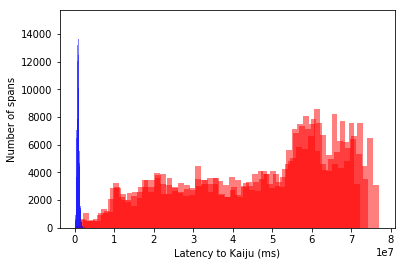

In [19]:
for i in range(3):
    max_lat = np.amax(j_t_diff[i])
    j_max_lat = np.amax(t_diff[i])
    min_lat = np.amin(j_t_diff[i])
    j_min_lat = np.amin(t_diff[i])
    bins = np.linspace(min(min_lat, j_min_lat), max(max_lat, j_max_lat), 10)
    print("TEST NUMBER " + str(i + 1))
    print("Min latency: Kaiju " + str(min_lat) + "ms Jaeger " + str(j_min_lat) + "ms")
    print("Max latency: Kaiju " + str(max_lat) + "ms Jaeger " + str(j_max_lat) + "ms")  
    print("*******************************************************************\n")

    pyplot.hist(j_t_diff[i], 50, alpha=0.5, color='r')
    pyplot.hist(t_diff[i], 50, alpha=0.5, color='b')

pyplot.xlabel('Latency to Kaiju (ms)')
pyplot.ylabel('Number of spans')
# pyplot.legend(loc='upper right')
pyplot.show()

In [20]:
ltrace_firstSpan = []
ltrace_lastSpan = []
lnumSpansPerTrace = []
lj_trace_firstSpan = []
lj_trace_lastSpan = []
lj_numSpansPerTrace = []

for j in range(3):
    traceIdinds = traceId[j].argsort()
    sortedByTrace_traceId = traceId[j][traceIdinds[::-1]]
    sortedByTrace_eventTime = eventTime[j][traceIdinds[::-1]]

    traces = np.unique(sortedByTrace_traceId).tolist()
    trace_firstSpan = np.zeros(len(traces), dtype='int64')
    trace_lastSpan = np.zeros(len(traces), dtype='int64')
    numSpansPerTrace = np.zeros(len(traces), dtype='int64')

    t = 0
    for trace in traces:
        i, = np.where(sortedByTrace_traceId == trace)
        sortedByTrace_eventTime_i = sortedByTrace_eventTime[i]
        sorted_sortedByTrace_eventTime_i = np.sort(sortedByTrace_eventTime_i)
        trace_firstSpan[t] = sorted_sortedByTrace_eventTime_i[0]
        trace_lastSpan[t] = sorted_sortedByTrace_eventTime_i[-1]
        numSpansPerTrace[t] = len(sortedByTrace_eventTime_i)
        t +=1
        
    ltrace_firstSpan.append(trace_firstSpan)
    ltrace_lastSpan.append(trace_lastSpan)
    lnumSpansPerTrace.append(numSpansPerTrace)
    
    # JAEGER
    
    j_traceIdinds = j_traceId[j].argsort()
    j_sortedByTrace_traceId = j_traceId[j][j_traceIdinds[::-1]]
    j_sortedByTrace_eventTime = j_eventTime[j][j_traceIdinds[::-1]]

    j_traces = np.unique(j_sortedByTrace_traceId).tolist()
    j_trace_firstSpan = np.zeros(len(j_traces), dtype='int64')
    j_trace_lastSpan = np.zeros(len(j_traces), dtype='int64')
    j_numSpansPerTrace = np.zeros(len(j_traces), dtype='int64')

    j_t = 0
    for trace in j_traces:
        i, = np.where(j_sortedByTrace_traceId == trace)
        j_sortedByTrace_eventTime_i = j_sortedByTrace_eventTime[i]
        j_sorted_sortedByTrace_eventTime_i = np.sort(j_sortedByTrace_eventTime_i)
        j_trace_firstSpan[j_t] = j_sorted_sortedByTrace_eventTime_i[0]
        j_trace_lastSpan[j_t] = j_sorted_sortedByTrace_eventTime_i[-1]
        j_numSpansPerTrace[j_t] = len(j_sortedByTrace_eventTime_i)
        j_t +=1
        
    lj_trace_firstSpan.append(j_trace_firstSpan)
    lj_trace_lastSpan.append(j_trace_lastSpan)
    lj_numSpansPerTrace.append(j_numSpansPerTrace)

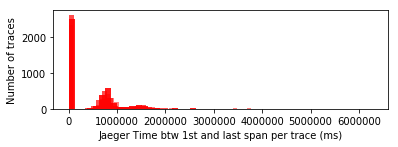

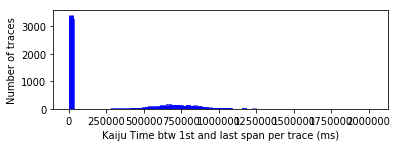

In [21]:
j_t_diff_per_trace = []

pyplot.subplot(2, 1, 1)
for i in range(3):
    j_t_diff_per_trace.append(np.subtract(lj_trace_lastSpan[i], lj_trace_firstSpan[i]))
    a = 0.5 + float("0." + str(i))*2
    l = "Jaeger " + str(i)
    pyplot.hist(j_t_diff_per_trace[-1], 50, alpha=a, color='r', label=l)
pyplot.xlabel('Jaeger Time btw 1st and last span per trace (ms)')
pyplot.ylabel('Number of traces')
pyplot.show()

t_diff_per_trace = []

pyplot.subplot(2, 1, 2)
for i in range(3):
    t_diff_per_trace.append(np.subtract(ltrace_lastSpan[i], ltrace_firstSpan[i]))
    a = 0.5 + float("0." + str(i))*2
    l = "Kaiju " + str(i)
    pyplot.hist(t_diff_per_trace[-1], 50, alpha=a, color='b', label=l)
pyplot.xlabel('Kaiju Time btw 1st and last span per trace (ms)')
pyplot.ylabel('Number of traces')
pyplot.show()

#Jaeger all spans of a trace almost together but higher latencies, notice also exceptions (high timestamps)

TEST NUMBER 1
Max diff 1st-last: Kaiju 1654061ms Jaeger 4713780ms
Min diff 1st-last: Kaiju 0ms Jaeger 0ms
*******************************************************************

TEST NUMBER 2
Max diff 1st-last: Kaiju 2028248ms Jaeger 5723970ms
Min diff 1st-last: Kaiju 0ms Jaeger 0ms
*******************************************************************

TEST NUMBER 3
Max diff 1st-last: Kaiju 1697538ms Jaeger 6287718ms
Min diff 1st-last: Kaiju 0ms Jaeger 0ms
*******************************************************************



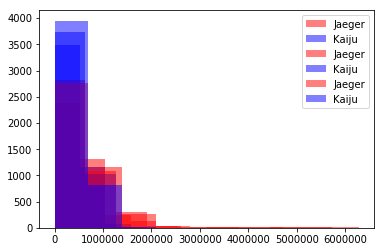

In [22]:
for i in range(3):
    max_lat = np.amax(t_diff_per_trace[i])
    j_max_lat = np.amax(j_t_diff_per_trace[i])
    min_lat = np.amin(t_diff_per_trace[i])
    j_min_lat = np.amin(j_t_diff_per_trace[i])
    bins = np.linspace(min(min_lat, j_min_lat), max(max_lat, j_max_lat), 10)
    print("TEST NUMBER " + str(i + 1))
    print("Max diff 1st-last: Kaiju " + str(max_lat) + "ms Jaeger " + str(j_max_lat) + "ms")
    print("Min diff 1st-last: Kaiju " + str(min_lat) + "ms Jaeger " + str(j_min_lat) + "ms")
    print("*******************************************************************\n")

    pyplot.hist(j_t_diff_per_trace[i], bins, alpha=0.5, label='Jaeger', color='r')
    pyplot.hist(t_diff_per_trace[i], bins, alpha=0.5, label='Kaiju', color='b')
    
pyplot.legend(loc='upper right')
pyplot.show()

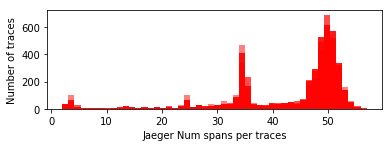

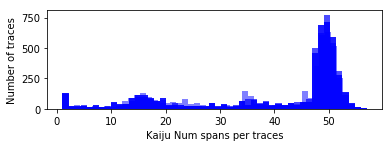

In [23]:
pyplot.subplot(2, 1, 1)
for i in range(3):
    a = 0.5 + float("0." + str(i))*2
    l = "Jaeger " + str(i)
    pyplot.hist(lj_numSpansPerTrace[i], 50, color='r', alpha=a, label=l)
pyplot.xlabel('Jaeger Num spans per traces')
pyplot.ylabel('Number of traces')
pyplot.show()

pyplot.subplot(2, 1, 2)
for i in range(3):
    a = 0.5 + float("0." + str(i))*2
    l = "Kaiju " + str(i)
    pyplot.hist(lnumSpansPerTrace[i], 50, color='b', alpha=a, label=l)
pyplot.xlabel('Kaiju Num spans per traces')
pyplot.ylabel('Number of traces')
pyplot.show()